In [1]:
!git clone https://github.com/v-like-engine/segmentuki

Cloning into 'segmentuki'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 119 (delta 0), reused 6 (delta 0), pack-reused 109
Receiving objects: 100% (119/119), 212.32 MiB | 25.31 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Updating files: 100% (23/23), done.


In [2]:
import sys
sys.path.append("segmentuki")
from models.pix2pixHD.pix2pixHD_model import Pix2PixHD
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm

In [3]:
class ADEDataset(Dataset):

    def __init__(self, root_path):
        self.img_path = root_path / "images/training"
        self.mask_path = root_path / "annotations/training"

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((128, 128))
        ])
        self.img_list = sorted(self._get_filenames(self.img_path))
        self.mask_list = sorted(self._get_filenames(self.mask_path))
        
        self._read_imgs()
        self._read_masks()
        
    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]
        return self.transform(img).float(), self.transform(mask).float()

    def __len__(self):
        return len(self.img_list)

    def _get_filenames(self, path):
        return [f for f in path.iterdir() if f.is_file()]

    def _read_imgs(self):
        self.images = [cv2.imread(str(f)) for f in self.img_list]

    def _read_masks(self):
        self.masks = [cv2.imread(str(f)) for f in self.mask_list]

In [4]:
input_dir = "/kaggle/input/ade20k-outdoors"
dataset = ADEDataset(Path(input_dir))

In [5]:
batch_size = 8
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, pin_memory=True
)

In [6]:
model_ade_30 = Pix2PixHD()
model_ade_30.load_state_dict(torch.load("/kaggle/working/segmentuki/models/pix2pixHD/weights/model_ade_128_30"))

<All keys matched successfully>

In [33]:
model_ade_150 = Pix2PixHD()
model_ade_150.load_state_dict(torch.load("/kaggle/working/segmentuki/models/pix2pixHD/weights/model_ade_128_150"))

<All keys matched successfully>

In [34]:
model_ade_200 = Pix2PixHD()
model_ade_200.load_state_dict(torch.load("/kaggle/working/segmentuki/models/pix2pixHD/weights/model_ade_128_200"))

<All keys matched successfully>

In [42]:
def draw(model, batch):
    images, masks = batch
    fig, axs = plt.subplots(batch_size, 3, figsize=(15, 15))
    model_outputs = model.inference(masks.to('cuda'))
    for i in range(batch_size):
        image = images[i].cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = (image * 255.0).astype("uint8")

        mask = masks[i].cpu().numpy()
        mask = mask.transpose((1, 2, 0))
        mask = (mask * 255.0).astype("uint8")

        model_output = model_outputs[i].squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
#         model_output = (model_output * 255.0).astype("uint8")

        axs[i, 0].imshow(image)
        axs[i, 1].imshow(mask)
        axs[i, 2].imshow(model_output)
        axs[i, 0].axis("off")
        axs[i, 1].axis("off")
        axs[i, 2].axis("off")
    plt.tight_layout()
    plt.show()

In [43]:
batch = next(iter(data_loader))

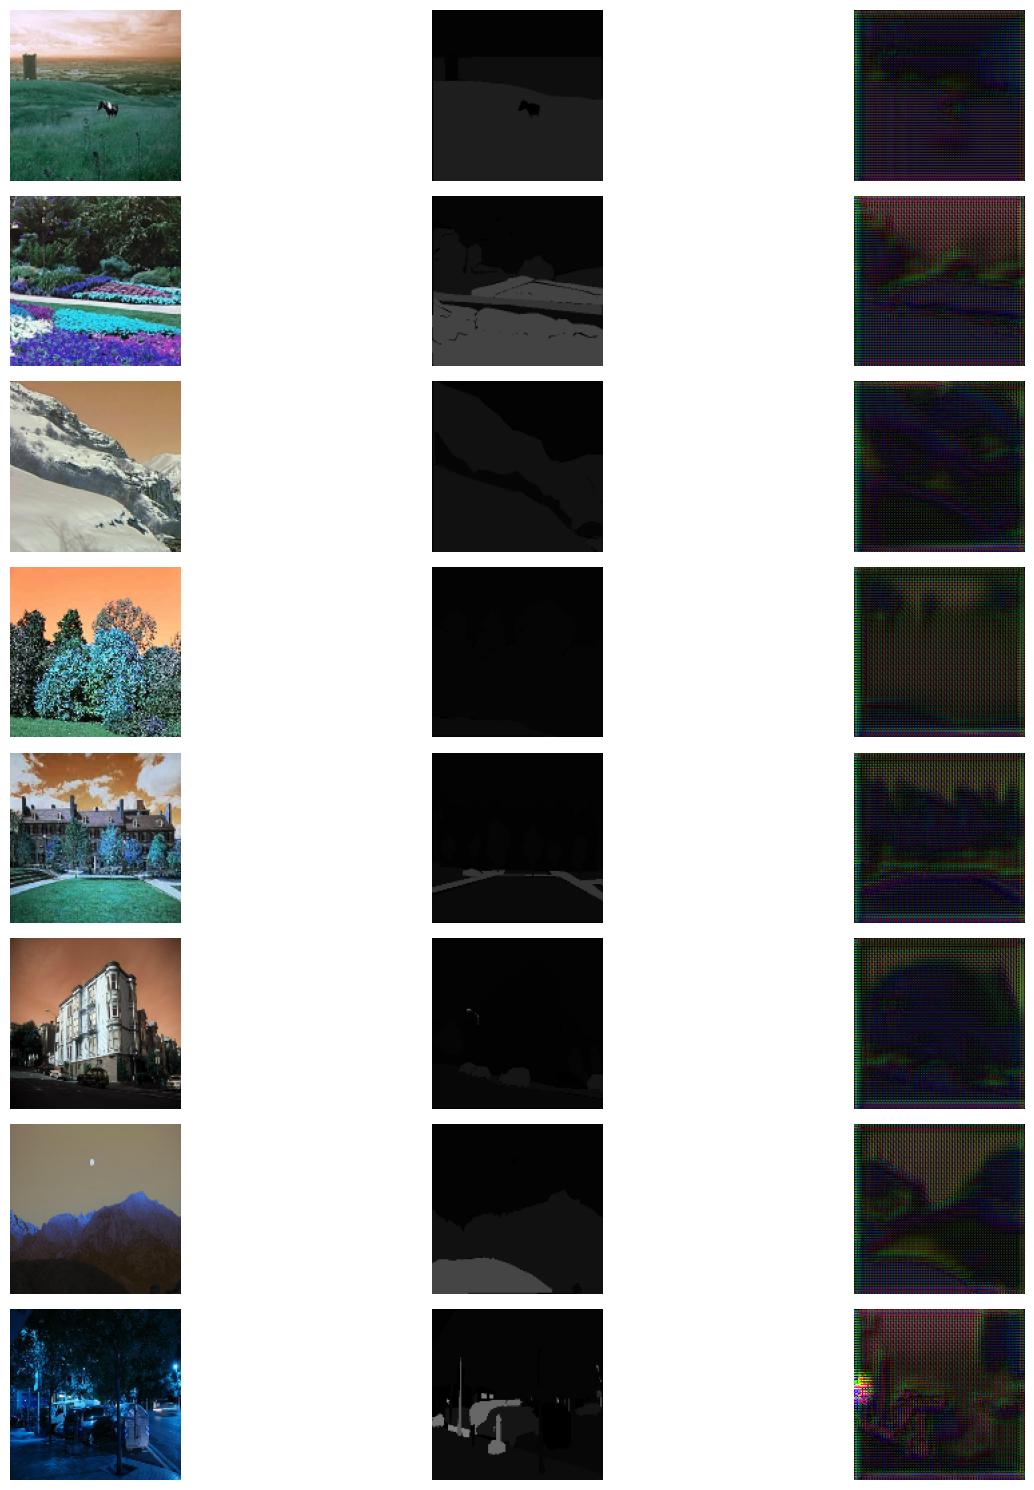

In [44]:
draw(model_ade_30, batch)

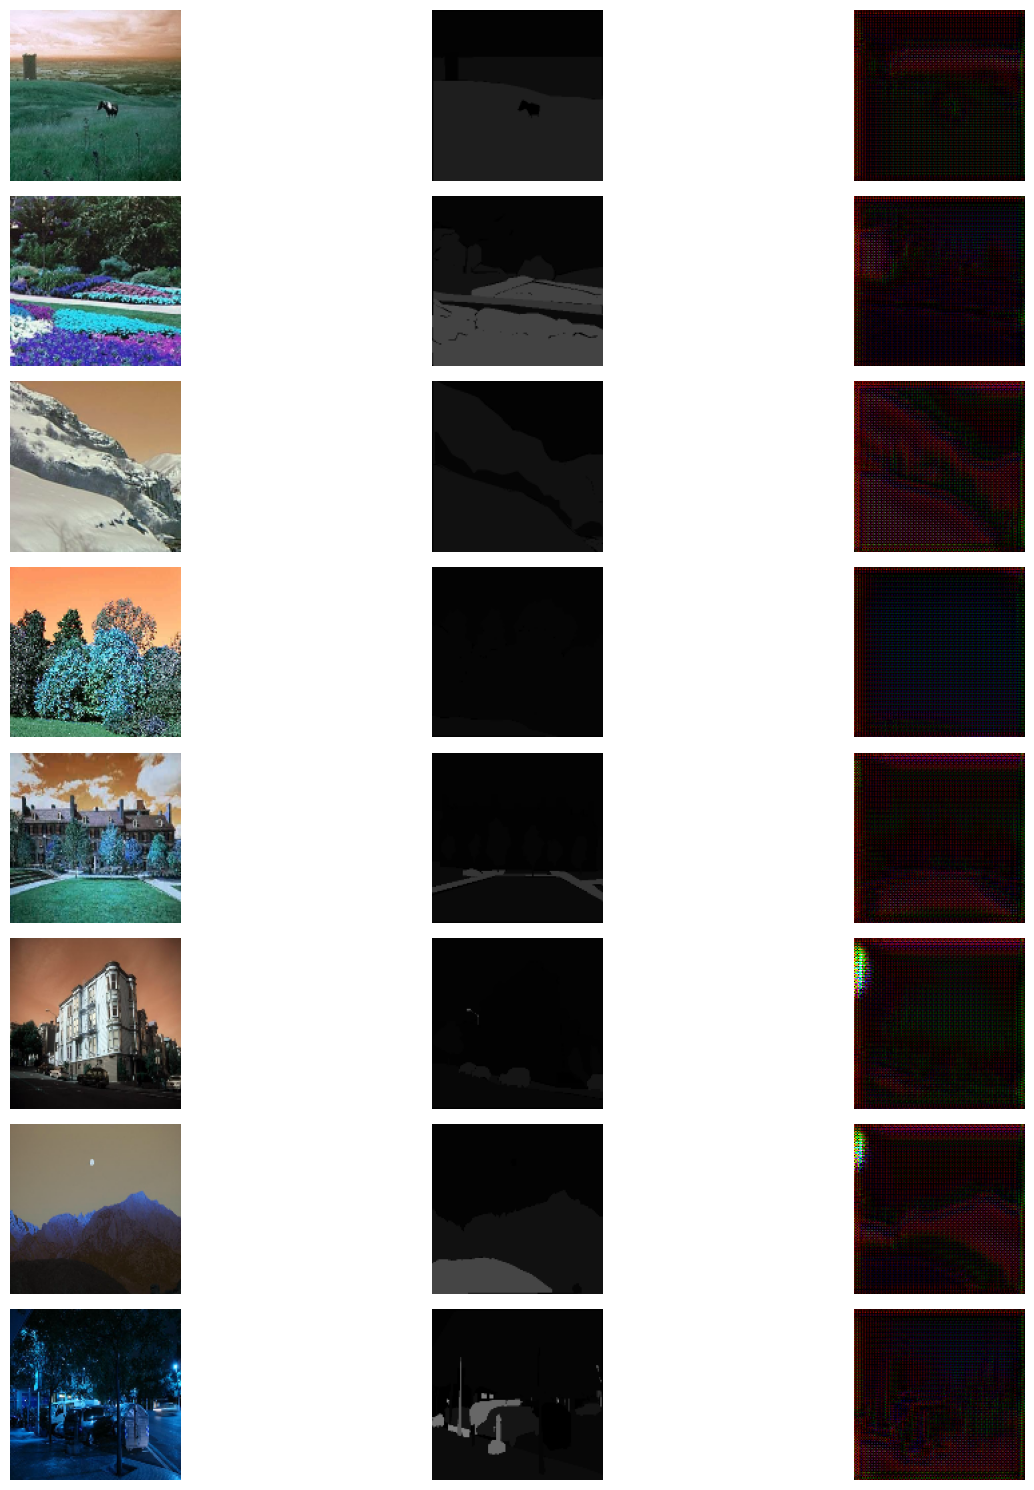

In [45]:
draw(model_ade_150, batch)

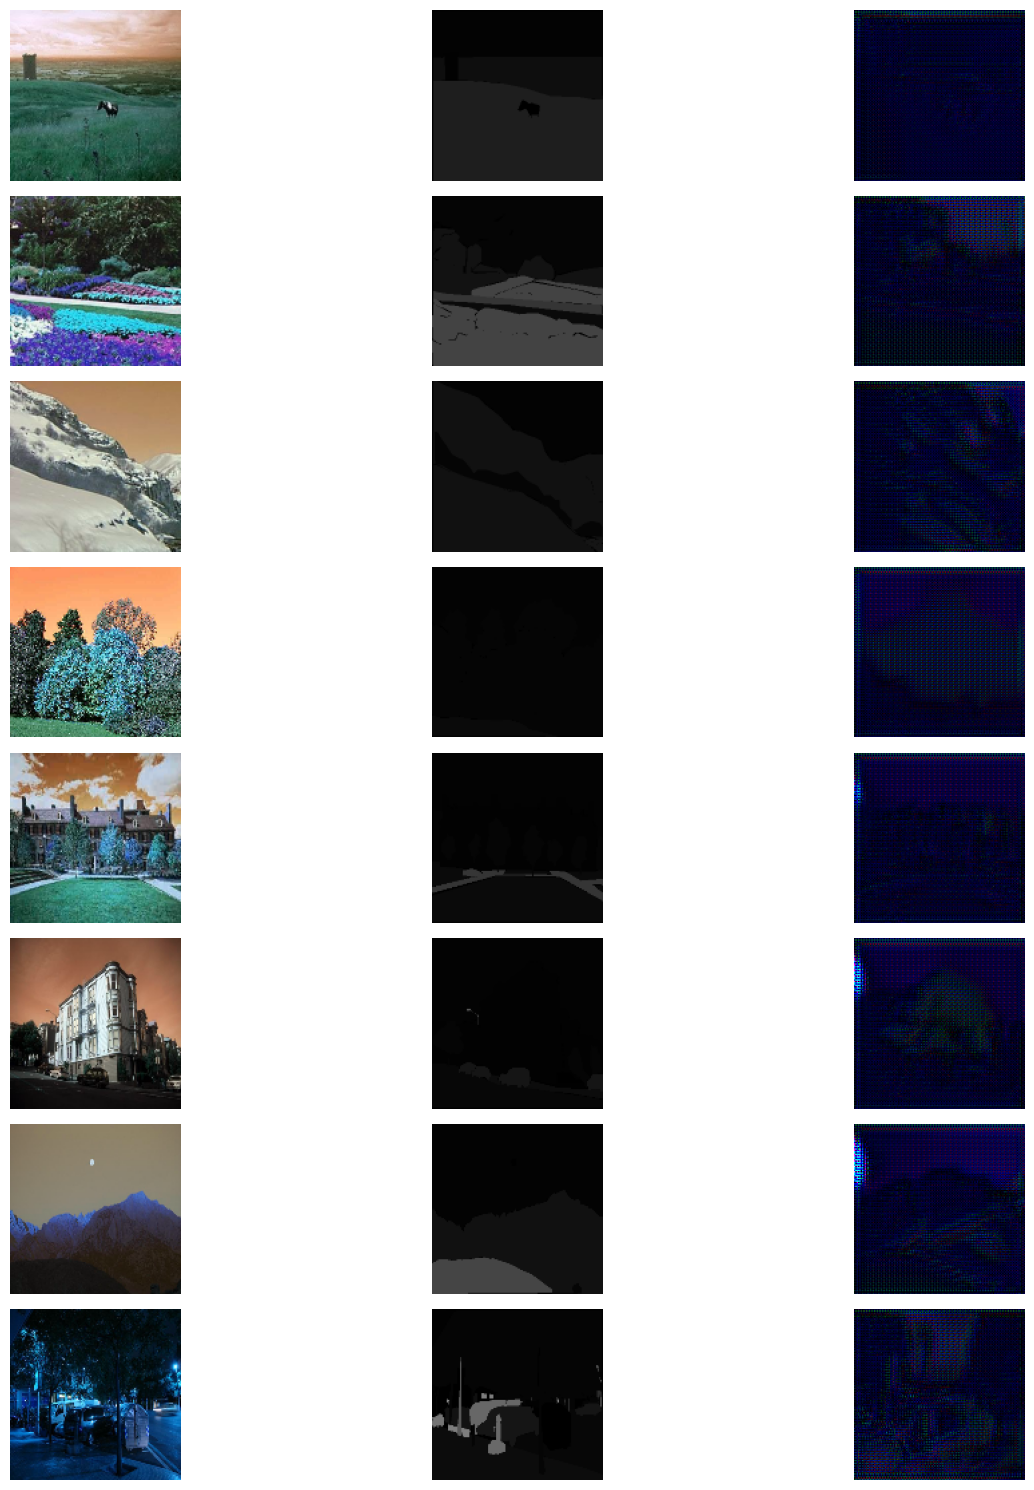

In [46]:
draw(model_ade_200, batch)